In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.preprocessing import image
from keras.models import Sequential
from keras.optimizers import SGD


In [ ]:
# convolution, dropout and max pool. layers added
opt = SGD(learning_rate = 0.001)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

from keras import regularizers

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# the final classification is done via fully connected layers
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()
# categorical crossentropy is used since there are 3 classes
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       7

In [ ]:
# image preprocessing and augmentation
train_datagen = image.ImageDataGenerator(
      rescale=1./256,
      shear_range=0.1, #0.2
      zoom_range=0.1, #0.2
      horizontal_flip=True,
      )
test_dataset = image.ImageDataGenerator(rescale=1./256)

In [ ]:
#Take the path to a directory
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset-xgboost/training',
    target_size = (256,256),
    color_mode = 'rgb',
    batch_size = 32, 
    class_mode= 'categorical'
)

Found 1263 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [ ]:
# take validation path to a directory
validation_generator = test_dataset.flow_from_directory(
    '/content/drive/MyDrive/dataset-xgboost/validation',
    target_size = (256,256),
    batch_size = 32, 
    class_mode = 'categorical',
    shuffle = False
)


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

#Configure the model for training
history = model.fit(train_generator,
                    steps_per_epoch=40, 
                    validation_data=validation_generator,
                    validation_steps=2, 
                    epochs=100,
         )


Found 464 images belonging to 3 classes.
Epoch 1/100
40/40 [==============================] - 528s 12s/step - loss: 1.8210 - accuracy: 0.4704 - val_loss: 0.5366 - val_accuracy: 0.8594
Epoch 2/100
40/40 [==============================] - 20s 488ms/step - loss: 0.7335 - accuracy: 0.7304 - val_loss: 0.5403 - val_accuracy: 0.9062
Epoch 3/100
40/40 [==============================] - 20s 487ms/step - loss: 0.5846 - accuracy: 0.8214 - val_loss: 0.6942 - val_accuracy: 0.8438
Epoch 4/100
40/40 [==============================] - 20s 489ms/step - loss: 0.5355 - accuracy: 0.8240 - val_loss: 0.4630 - val_accuracy: 0.9062
Epoch 5/100
40/40 [==============================] - 20s 487ms/step - loss: 0.4909 - accuracy: 0.8670 - val_loss: 0.6918 - val_accuracy: 0.7969
Epoch 6/100
40/40 [==============================] - 20s 493ms/step - loss: 0.4182 - accuracy: 0.8861 - val_loss: 0.5126 - val_accuracy: 0.8438
Epoch 7/100
40/40 [==============================] - 19s 481ms/step - loss: 0.4082 - accuracy: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


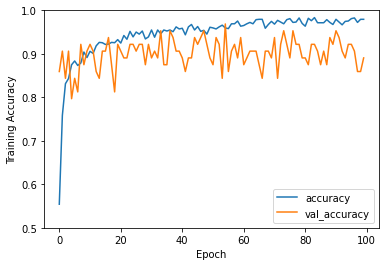

In [ ]:
print(history.history.keys())
# plot model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')



In [ ]:
# save the model
model.save("network.h5")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(validation_generator, 464 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['covid', 'normal', 'pneumonia']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[131   6   3]
 [  0 152   4]
 [  1   0 167]]
Classification Report
              precision    recall  f1-score   support

       covid       0.99      0.94      0.96       140
      normal       0.96      0.97      0.97       156
   pneumonia       0.96      0.99      0.98       168

    accuracy                           0.97       464
   macro avg       0.97      0.97      0.97       464
weighted avg       0.97      0.97      0.97       464

